#This notebook computes the spectrum of the diagonal Jacobian


In [2]:
%%capture
!pip install ipython-autotime
!pip install pytorchcv
!pip install powerlaw
%load_ext autotime

time: 6.45 s


In [3]:
!pip install GPUtil
import GPUtil


GPUtil.showUtilization()

  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=1a5758ec81cc913bb5a915ce4c6fa3d3a7cc094c8c5dd7e6396e80679b5d4ca1
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
time: 4.17 s


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
time: 18.6 s


#change directory into folder with jacobian.py and utils.py

In [5]:
cd /content/drive/My Drive/sketch_J

/content/drive/My Drive/sketch_J
time: 7.64 ms


In [6]:
from utils import *
from jacobian import *

time: 10.5 s


In [7]:
import pytorchcv
from pytorchcv.model_provider import get_model as ptcv_get_model

import powerlaw
for modelname in pytorchcv.model_provider._models.keys():
    if modelname.startswith('resnet') and modelname.endswith('cifar10'):
        print(modelname)

resnet20_cifar10
resnet56_cifar10
resnet110_cifar10
resnet164bn_cifar10
resnet272bn_cifar10
resnet542bn_cifar10
resnet1001_cifar10
resnet1202_cifar10
time: 97.5 ms


In [8]:
thismodel = 'resnet20_cifar10'
model = ptcv_get_model(thismodel, pretrained=True)
train_dataset, _, train_loader, _ = get_data(batch_size=100)
full_J = construct_diagJ(model, train_loader, batch_size=100, device='cuda:0') # The P100 on Colab should have enough memory to do this


Files already downloaded and verified
Files already downloaded and verified
time: 1min 19s


In [9]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 81% |
time: 48.7 ms


In [10]:
M = sketch_JL_JJT(full_J, dim=10000, device="cuda:0") #just enough memory to do this with P100

time: 6.09 s


In [12]:
del full_J

time: 820 µs


In [13]:
u, v = torch.eig(M)

time: 7min 11s


(array([2.942e+03, 1.309e+03, 8.430e+02, 6.180e+02, 4.890e+02, 3.970e+02,
        3.320e+02, 2.850e+02, 2.470e+02, 2.160e+02, 1.910e+02, 1.720e+02,
        1.540e+02, 1.390e+02, 1.270e+02, 1.150e+02, 1.040e+02, 9.600e+01,
        8.700e+01, 8.300e+01, 7.600e+01, 6.900e+01, 6.500e+01, 5.800e+01,
        5.500e+01, 5.000e+01, 4.800e+01, 4.300e+01, 4.200e+01, 3.800e+01,
        3.600e+01, 3.400e+01, 3.000e+01, 2.800e+01, 2.800e+01, 2.500e+01,
        2.500e+01, 2.200e+01, 2.000e+01, 1.900e+01, 1.800e+01, 1.700e+01,
        1.500e+01, 1.400e+01, 1.400e+01, 1.200e+01, 1.100e+01, 1.200e+01,
        9.000e+00, 8.000e+00, 1.000e+01, 9.000e+00, 8.000e+00, 6.000e+00,
        6.000e+00, 6.000e+00, 6.000e+00, 4.000e+00, 5.000e+00, 4.000e+00,
        4.000e+00, 4.000e+00, 2.000e+00, 4.000e+00, 3.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 4.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 2.000e+0

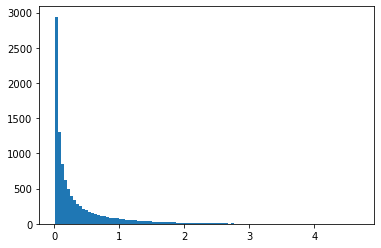

time: 303 ms


In [15]:
import matplotlib.pyplot as plt

plt.hist(u[:,0].detach().cpu().numpy(), bins=100)

In [16]:
t = u[:,0].detach().cpu().numpy()

time: 1.07 ms


Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


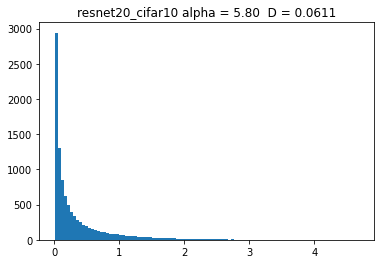

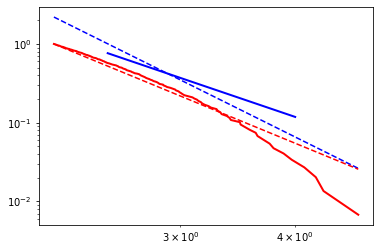

time: 14.2 s


In [17]:
fit = powerlaw.Fit(t)
alpha = fit.power_law.alpha
D = fit.power_law.D
title = "{} alpha = {:04.2f}  D = {:04.4f}".format(thismodel, alpha, D)
plt.title(title)
plt.hist(t, bins=100)
plt.show()

fig2 = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
fit.plot_ccdf(color='r', linewidth=2, ax=fig2)
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)
plt.show()

